In [2]:
pip install -q "pytorch-lightning<2.0.0"

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q transformers datasets roboflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [5]:
import evaluate

metric = evaluate.load("accuracy")


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-07 06:32:09.061859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 06:32:09.065608: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 06:32:09.073385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 06:32:09.087065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to r

In [6]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
import evaluate

metric = evaluate.load("accuracy")


In [7]:
import roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rWhzxDa8oLFF7F6zw3cG")
project = rf.workspace("cd-pq7yy").project("building-defects-xpjmz")
version = project.version(2)
dataset = version.download("png-mask-semantic")
                

loading Roboflow workspace...
loading Roboflow project...


In [24]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        
        # Load class mapping from CSV file (e.g., _classes.csv)
        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i, l in enumerate(fid) if i != 0]
        self.id2label = {x[0]: x[1] for x in data}
        
        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]
        
        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))

        # Convert segmentation map to numpy array (without ignoring any labels)
        segmentation_map = np.array(segmentation_map)

        # Apply feature extractor to both image and segmentation map
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        # Remove batch dimension
        for k, v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()

        return encoded_inputs
    

In [10]:
class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        
        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b4-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        
        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        
    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)
    
    def training_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            
            for k,v in metrics.items():
                self.log(k,v)
            
            return(metrics)
        else:
            return({'loss': loss})
    
    def validation_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        
        return({'val_loss': loss})
    
    def validation_epoch_end(self, outputs):
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
        
        avg_val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]
        
        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        return metrics
    
    def test_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
            
        return({'test_loss': loss})
    
    def test_epoch_end(self, outputs):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
       
        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}
        
        for k,v in metrics.items():
            self.log(k,v)
        
        return metrics
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl
    

        

In [19]:
import torch

# IoU 계산 함수
def compute_iou(predictions, targets, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = predictions == cls
        target_inds = targets == cls
        intersection = torch.sum(pred_inds & target_inds)
        union = torch.sum(pred_inds | target_inds)
        if union == 0:
            ious.append(float('nan'))  # NaN 대신 다른 값으로 처리 가능
        else:
            ious.append(float(intersection) / float(union))
    return torch.tensor(ious).nanmean()  # NaN을 제외한 평균 IoU 계산

# SegFormer fine-tuning 클래스
class SegformerFinetuner(pl.LightningModule):
    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        
        self.num_classes = len(id2label.keys())
        self.label2id = {v: k for k, v in self.id2label.items()}
        
        # Pretrained SegFormer 모델 로드
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b4-finetuned-ade-512-512",
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True
        )

    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return outputs

    def training_step(self, batch, batch_nb):
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        loss, logits = outputs[0], outputs[1]

        # Logits upsampling to match mask size
        upsampled_logits = torch.nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        # IoU 계산
        mean_iou = compute_iou(predicted, masks, self.num_classes)
        
        metrics = {'loss': loss, 'mean_iou': mean_iou}
        
        if batch_nb % self.metrics_interval == 0:
            for k, v in metrics.items():
                self.log(k, v)

        return metrics

    def validation_step(self, batch, batch_nb):
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        loss, logits = outputs[0], outputs[1]

        # Logits upsampling to match mask size
        upsampled_logits = torch.nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        # IoU 계산
        mean_iou = compute_iou(predicted, masks, self.num_classes)
        
        return {'val_loss': loss, 'val_mean_iou': mean_iou}

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_val_mean_iou = torch.stack([x["val_mean_iou"] for x in outputs]).mean()

        metrics = {"val_loss": avg_val_loss, "val_mean_iou": avg_val_mean_iou}
        for k, v in metrics.items():
            self.log(k, v)

        return metrics

    def test_step(self, batch, batch_nb):
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        loss, logits = outputs[0], outputs[1]

        # Logits upsampling to match mask size
        upsampled_logits = torch.nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        # IoU 계산
        mean_iou = compute_iou(predicted, masks, self.num_classes)
        
        return {'test_loss': loss, 'test_mean_iou': mean_iou}

    def test_epoch_end(self, outputs):
        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        avg_test_mean_iou = torch.stack([x["test_mean_iou"] for x in outputs]).mean()

        metrics = {"test_loss": avg_test_loss, "test_mean_iou": avg_test_mean_iou}
        for k, v in metrics.items():
            self.log(k, v)

        return metrics

    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl


In [38]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"


In [26]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
feature_extractor.do_reduce_labels = False
feature_extractor.size = 512

train_dataset = SemanticSegmentationDataset(f"{dataset.location}/train/", feature_extractor)
val_dataset = SemanticSegmentationDataset(f"{dataset.location}/valid/", feature_extractor)
test_dataset = SemanticSegmentationDataset(f"{dataset.location}/test/", feature_extractor)

batch_size = 4
num_workers = 0
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([5, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=10, 
    verbose=False, 
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    gpus=[1], 
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=500,
    val_check_interval=len(train_dataloader),
)
trainer.fit(segformer_finetuner)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 64.0 M
-----------------------------------------------------------
64.0 M    Trainable params
0         Non-trainable params
64.0 M    Total params
255.987   Total estimated model params size (MB)


The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Epoch 0:  79%|███████▊  | 11/14 [00:05<00:01,  1.98it/s, loss=1.6, v_num=18] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  86%|████████▌ | 12/14 [00:05<00:00,  2.17it/s, loss=1.49, v_num=18]
Validating: 0it [00:00, ?it/s]
Epoch 2:  86%|████████▌ | 12/14 [00:05<00:00,  2.14it/s, loss=1.32, v_num=18]
Validating: 0it [00:00, ?it/s]
Epoch 3:  86%|████████▌ | 12/14 [00:05<00:00,  2.16it/s, loss=1.17, v_num=18]
Validating: 0it [00:00, ?it/s]
Epoch 4:  86%|████████▌ | 12/14 [00:05<00:00,  2.14it/s, loss=1.03, v_num=18]
Validating: 0it [00:00, ?it/s]
Epoch 5:  86%|████████▌ | 12/14 [00:05<00:00,  2.13it/s, loss=0.918, v_num=18]
Validating: 0it [00:00, ?it/s]
Epoch 6:  86%|████████▌ | 12/14 [00:05<00:00,  2.16it/s, loss=0.822, v_num=18]
Validating: 0it [00:00, ?it/s]
Epoch 7:  86%|████████▌ | 12/14 [00:05<00:00,  2.13it/s, loss=0.741, v_num=18]
Validating: 0it [00:00, ?it/s]
Epoch 8:  86%|████████▌ | 12/14 [00:05<00:00,  2.14it/s, loss=0.672, v_num=18]
Validating: 0it [00:00, ?it/s]
Epoch 9:  86%|█

1

In [12]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

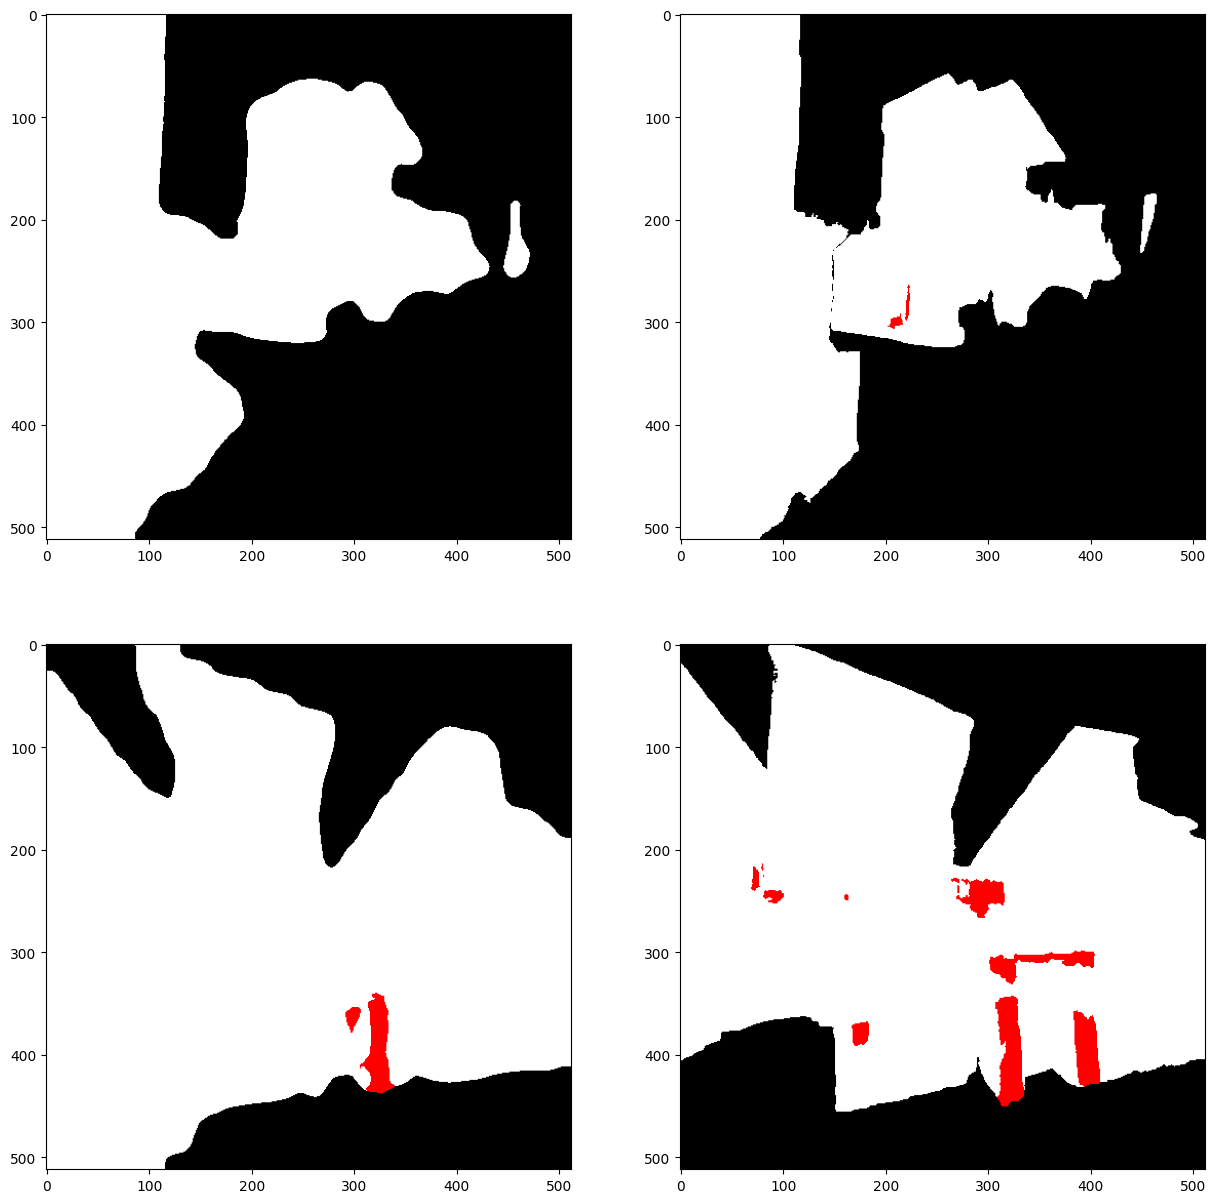

In [32]:
color_map = {
    0:(0,0,0),
    1:(255,255,255),
    2:(255,0,0)
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in test_dataloader:
    images, masks = batch['pixel_values'], batch['labels']
    outputs = segformer_finetuner.model(images, masks)
        
    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits, 
        size=masks.shape[-2:], 
        mode="bilinear", 
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

# 배치 크기에 맞춰 n_plots 값 설정
n_plots = min(4, len(predicted_mask))  # 배치 크기가 2이면 n_plots도 2로 설정

from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots, 2)
f.set_figheight(15)
f.set_figwidth(15)

# 예측된 마스크와 실제 마스크를 시각화
for i in range(n_plots):
    axarr[i, 0].imshow(prediction_to_vis(predicted_mask[i, :, :]))  # 예측된 마스크
    axarr[i, 1].imshow(prediction_to_vis(masks[i, :, :]))          # 실제 마스크


In [33]:
#Predict on a test image and overlay the mask on the original image
test_idx = 2
input_image_file = os.path.join(test_dataset.root_dir,test_dataset.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = test_dataset[test_idx]
images, masks = test_batch['pixel_values'], test_batch['labels']
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
outputs = segformer_finetuner.model(images, masks)
    
loss, logits = outputs[0], outputs[1]

upsampled_logits = nn.functional.interpolate(
    logits, 
    size=masks.shape[-2:], 
    mode="bilinear", 
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
mask = prediction_to_vis(np.squeeze(masks))
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)

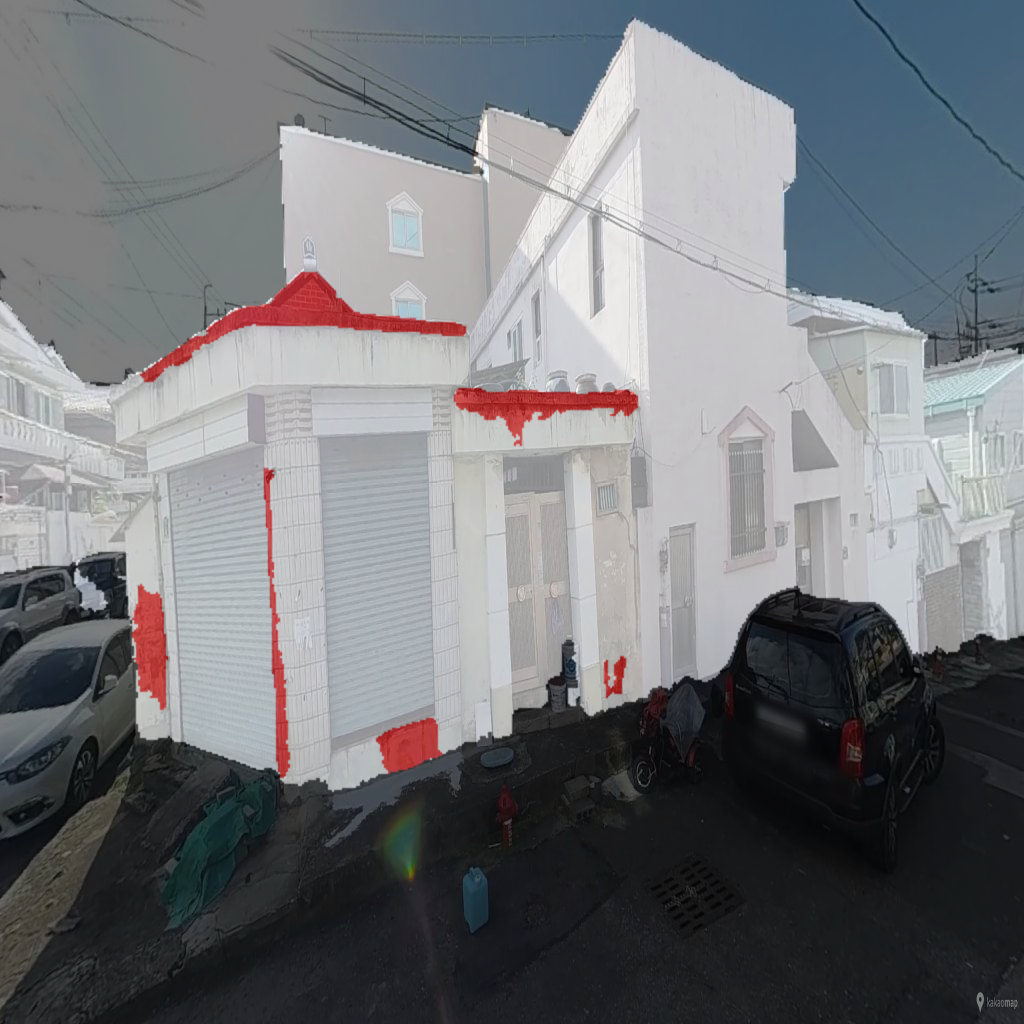

In [34]:
overlay_img

In [31]:
# 각 클래스가 예측된 픽셀 수를 확인하는 코드
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy().squeeze()
unique, counts = np.unique(predicted_mask, return_counts=True)
print(dict(zip(unique, counts)))  # 각 클래스별 픽셀 수 확인


{0: 110825, 1: 148627, 2: 2692}


In [35]:
import os
from PIL import Image
import torch
import numpy as np

# Color map 설정 (배경, 건물, 크랙 등)
color_map = {
    0: (0, 0, 0),      # 배경
    1: (255, 255, 255),  # 건물
    2: (255, 0, 0),     # 크랙
}

# 예측된 마스크를 시각화하는 함수
def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i, c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

# 이미지 전처리 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs, image

# 폴더 내 모든 이미지에 대해 inference를 수행하고 결과를 시각화하는 함수
def run_inference_on_folder(folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # 결과를 저장할 폴더 생성

    for file_name in os.listdir(folder_path):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일만 처리
            image_path = os.path.join(folder_path, file_name)
            inputs, input_image = preprocess_image(image_path)

            # 모델 추론
            with torch.no_grad():
                outputs = segformer_finetuner.model(pixel_values=inputs['pixel_values'])

            logits = outputs.logits
            upsampled_logits = torch.nn.functional.interpolate(
                logits,
                size=(input_image.size[1], input_image.size[0]),
                mode="bilinear",
                align_corners=False
            )

            # 각 픽셀에서 가장 가능성 높은 클래스를 선택
            predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()[0]

            # 시각화
            mask = prediction_to_vis(predicted_mask)
            mask = mask.resize(input_image.size)
            mask = mask.convert("RGBA")

            # 원본 이미지와 예측된 마스크를 오버레이
            input_image = input_image.convert("RGBA")
            overlay_img = Image.blend(input_image, mask, 0.5)

            # 결과 이미지 저장
            output_path = os.path.join(output_folder, f"segmented_{file_name}")
            overlay_img.save(output_path)
            print(f"Saved segmented image with overlay: {output_path}")

# 사용 예시
input_folder = "sv_data"  # 추론할 이미지가 있는 폴더 경로
output_folder = "ft_model_infer_result"  # 결과를 저장할 폴더 경로
run_inference_on_folder(input_folder, output_folder)


Saved segmented image with overlay: ft_model_infer_result/segmented_18.png
Saved segmented image with overlay: ft_model_infer_result/segmented_56.png
Saved segmented image with overlay: ft_model_infer_result/segmented_58.png
Saved segmented image with overlay: ft_model_infer_result/segmented_11.png
Saved segmented image with overlay: ft_model_infer_result/segmented_20.png
Saved segmented image with overlay: ft_model_infer_result/segmented_14.png
Saved segmented image with overlay: ft_model_infer_result/segmented_13.png
Saved segmented image with overlay: ft_model_infer_result/segmented_47.png
Saved segmented image with overlay: ft_model_infer_result/segmented_30.png
Saved segmented image with overlay: ft_model_infer_result/segmented_19.png
Saved segmented image with overlay: ft_model_infer_result/segmented_15.png
Saved segmented image with overlay: ft_model_infer_result/segmented_48.png
Saved segmented image with overlay: ft_model_infer_result/segmented_22.png
Saved segmented image wit

In [36]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# IoU 계산 함수
def compute_iou(predictions, targets, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = predictions == cls
        target_inds = targets == cls
        intersection = np.sum(pred_inds & target_inds)
        union = np.sum(pred_inds | target_inds)
        if union == 0:
            ious.append(float('nan'))  # NaN 대신 처리할 값을 넣을 수 있음
        else:
            ious.append(float(intersection) / float(union))
    return np.nanmean(ious)  # NaN을 제외한 평균 IoU

# 클래스별로 정밀도, 재현율, F1-score, 정확도 계산 함수
def compute_classwise_metrics(predictions, targets, num_classes):
    precision = precision_score(targets.flatten(), predictions.flatten(), average=None, labels=range(num_classes))
    recall = recall_score(targets.flatten(), predictions.flatten(), average=None, labels=range(num_classes))
    f1 = f1_score(targets.flatten(), predictions.flatten(), average=None, labels=range(num_classes))
    accuracy = accuracy_score(targets.flatten(), predictions.flatten())
    
    return precision, recall, f1, accuracy

# 모델 추론 및 성능 지표 계산 함수
def evaluate_model_on_test_data(dataloader, model, num_classes):
    iou_list = []
    precision_list, recall_list, f1_list = [], [], []
    
    for batch in dataloader:
        images, masks = batch['pixel_values'], batch['labels']
        
        with torch.no_grad():
            outputs = model(pixel_values=images)
        
        logits = outputs.logits
        upsampled_logits = torch.nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
        masks = masks.cpu().numpy()

        # IoU 계산
        iou = compute_iou(predicted_mask, masks, num_classes)
        iou_list.append(iou)

        # 정밀도, 재현율, F1-score 계산
        precision, recall, f1, accuracy = compute_classwise_metrics(predicted_mask, masks, num_classes)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    avg_iou = np.mean(iou_list)
    avg_precision = np.mean(precision_list, axis=0)
    avg_recall = np.mean(recall_list, axis=0)
    avg_f1 = np.mean(f1_list, axis=0)

    return avg_iou, avg_precision, avg_recall, avg_f1, accuracy

# 모델 성능 평가
num_classes = 3  # 클래스 개수
avg_iou, avg_precision, avg_recall, avg_f1, accuracy = evaluate_model_on_test_data(test_dataloader, segformer_finetuner.model, num_classes)

# 결과 출력
print(f"Average IoU: {avg_iou}")
for cls in range(num_classes):
    print(f"Class {cls}: Precision={avg_precision[cls]}, Recall={avg_recall[cls]}, F1-score={avg_f1[cls]}")
print(f"Overall Accuracy: {accuracy}")


Average IoU: 0.6401037027162065
Class 0: Precision=0.9521282711658452, Recall=0.924369820977933, F1-score=0.9376567917879318
Class 1: Precision=0.9197735984045672, Recall=0.9560192743221871, F1-score=0.9372797734460621
Class 2: Precision=0.44871102105144656, Recall=0.19797311110973065, F1-score=0.26883449824958405
Overall Accuracy: 0.9253520965576172


Average IoU: 0.6514506550116355
Class 0: Precision=0.9569296395708959, Recall=0.9261888719680288, F1-score=0.9410294124400544
Class 1: Precision=0.9197666588711573, Recall=0.9610995396106935, F1-score=0.9398248219484175
Class 2: Precision=0.5351062447093144, Recall=0.21163484562657436, F1-score=0.30223105667938055
Overall Accuracy: 0.9281654357910156


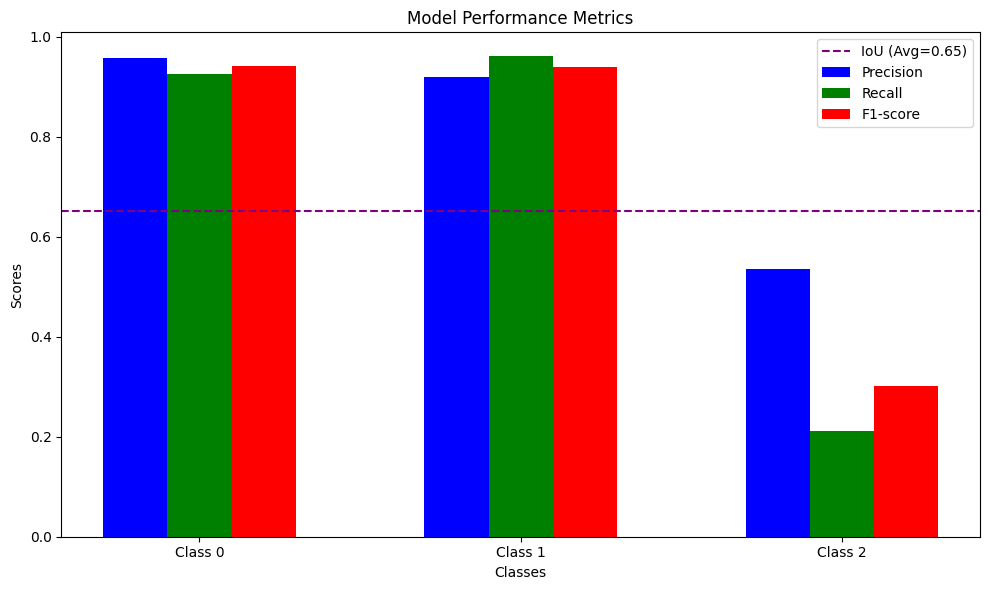

In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# IoU 계산 함수
def compute_iou(predictions, targets, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = predictions == cls
        target_inds = targets == cls
        intersection = np.sum(pred_inds & target_inds)
        union = np.sum(pred_inds | target_inds)
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(float(intersection) / float(union))
    return np.nanmean(ious)

# 클래스별로 정밀도, 재현율, F1-score, 정확도 계산 함수
def compute_classwise_metrics(predictions, targets, num_classes):
    precision = precision_score(targets.flatten(), predictions.flatten(), average=None, labels=range(num_classes))
    recall = recall_score(targets.flatten(), predictions.flatten(), average=None, labels=range(num_classes))
    f1 = f1_score(targets.flatten(), predictions.flatten(), average=None, labels=range(num_classes))
    accuracy = accuracy_score(targets.flatten(), predictions.flatten())
    
    return precision, recall, f1, accuracy

# 모델 추론 및 성능 지표 계산 함수
def evaluate_model_on_test_data(dataloader, model, num_classes):
    iou_list = []
    precision_list, recall_list, f1_list = [], [], []
    
    for batch in dataloader:
        images, masks = batch['pixel_values'], batch['labels']
        
        with torch.no_grad():
            outputs = model(pixel_values=images)
        
        logits = outputs.logits
        upsampled_logits = torch.nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
        masks = masks.cpu().numpy()

        # IoU 계산
        iou = compute_iou(predicted_mask, masks, num_classes)
        iou_list.append(iou)

        # 정밀도, 재현율, F1-score 계산
        precision, recall, f1, accuracy = compute_classwise_metrics(predicted_mask, masks, num_classes)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    avg_iou = np.mean(iou_list)
    avg_precision = np.mean(precision_list, axis=0)
    avg_recall = np.mean(recall_list, axis=0)
    avg_f1 = np.mean(f1_list, axis=0)

    return avg_iou, avg_precision, avg_recall, avg_f1, accuracy

# 모델 성능 평가
num_classes = 3  # 클래스 개수
avg_iou, avg_precision, avg_recall, avg_f1, accuracy = evaluate_model_on_test_data(test_dataloader, segformer_finetuner.model, num_classes)

# 결과 출력
print(f"Average IoU: {avg_iou}")
for cls in range(num_classes):
    print(f"Class {cls}: Precision={avg_precision[cls]}, Recall={avg_recall[cls]}, F1-score={avg_f1[cls]}")
print(f"Overall Accuracy: {accuracy}")

# 성능 지표를 그래프로 시각화
classes = [f"Class {i}" for i in range(num_classes)]
bar_width = 0.2
index = np.arange(num_classes)

plt.figure(figsize=(10, 6))

# 정밀도, 재현율, F1-score, IoU 시각화
plt.bar(index, avg_precision, bar_width, label='Precision', color='blue')
plt.bar(index + bar_width, avg_recall, bar_width, label='Recall', color='green')
plt.bar(index + 2 * bar_width, avg_f1, bar_width, label='F1-score', color='red')
plt.axhline(y=avg_iou, color='purple', linestyle='--', label=f'IoU (Avg={avg_iou:.2f})')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.xticks(index + bar_width, classes)
plt.legend()

plt.tight_layout()
plt.show()
